In [45]:
import torch
import os
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
from sklearn.metrics import accuracy_score

In [46]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [47]:
train_dir = '/kaggle/input/capstone-dataset1/capstone/train'
test_dir = '/kaggle/input/capstone-dataset1/capstone/test'

# **Create Datasets and Dataloaders**

In [48]:
NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):
    
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  class_names = train_data.classes

  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [49]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [50]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7ee0a43bc130>,
 ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])

torch.Size([3, 224, 224]) tensor(3)


IndexError: list index out of range

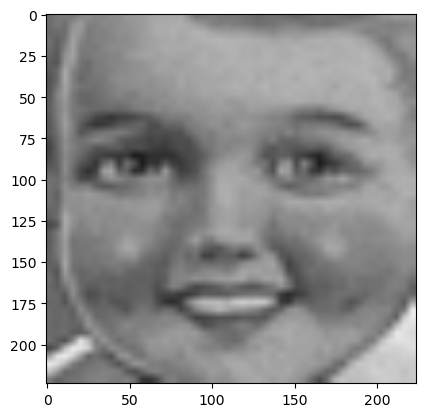

In [79]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

print(image.shape, label)

plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

# **Create PatchEmbedding Layer**

In [52]:
class PatchEmbedding(nn.Module):
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        self.flatten = nn.Flatten(start_dim=2,end_dim=3)

    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)

        return x_flattened.permute(0, 2, 1)

In [53]:
patch_size =16

def set_seeds(seed: int=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seeds()

patchify = PatchEmbedding(in_channels=3,patch_size=16,embedding_dim=768)

print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [54]:
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.5578,  0.1347, -0.1240,  ...,  0.3694, -0.2091,  0.1767],
         [-0.5898,  0.1402, -0.1703,  ...,  0.4076, -0.2242,  0.2514],
         [-0.5859,  0.1698, -0.1626,  ...,  0.4401, -0.2592,  0.1800],
         ...,
         [-0.7514,  0.2499, -0.2516,  ...,  0.5544, -0.2312,  0.2067],
         [-0.8409,  0.2361, -0.2433,  ...,  0.6291, -0.3667,  0.2887],
         [-0.8179,  0.2232, -0.2290,  ...,  0.6221, -0.3762,  0.2933]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [55]:
set_seeds()

patch_size = 16

print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

patch_embedding_layer = PatchEmbedding(in_channels=3,patch_size=patch_size,embedding_dim=768)

patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
print(f"Class token embedding shape: {class_token.shape}")

patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) 


patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

print(patch_embedding_class_token) 

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])
tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.5578,  0.1347, -0.1240,  ...,  0.3694, -0.2091,  0.1767],
         [-0.5898,  0.1402, -0.1703,  ...,  0.4076, -0.2242,  0.2514],
         ...,
         [-0.7514,  0.2499, -0.2516,  ...,  0.5544, -0.2312,  0.2067],
         [-0.8409,  0.2361, -0.2433,  ...,  0.6291, -0.3667,  0.2887],
         [-0.8179,  0.2232, -0.2290,  ...,  0.6221, -0.3762,  0.2933]]],
       grad_fn=<CatBackward0>)


# **Create Transformer Encoder Layers**
## 1. **Multi Head Self Attention Block**
## 2. **Feed Forward Network**
## 3. **Layer Normalization**

In [56]:
class MultiheadSelfAttentionBlock(nn.Module):

    def __init__(self,
                 embedding_dim:int=768, 
                 num_heads:int=12, 
                 attn_dropout:float=0): 
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) 

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x,key=x,value=x,need_weights=False) 
        return attn_output

# **MultiLayer Perceptron Block (MLP)**

In [57]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768, 
                 mlp_size:int=3072,
                 dropout:float=0.1):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, out_features=embedding_dim), 
            nn.Dropout(p=dropout) 
        )
        
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

# **Create Transformer Encoder Block**

In [58]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768, 
                 num_heads:int=12, 
                 mlp_size:int=3072, 
                 mlp_dropout:float=0.1, 
                 attn_dropout:float=0): 
        super().__init__()

        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    def forward(self, x):
        x =  self.msa_block(x) + x
        x = self.mlp_block(x) + x
        return x

In [59]:
transformer_encoder_block = TransformerEncoderBlock()

from torchinfo import summary
# Print an input and output summary of our Transformer Encoder
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

# **Build Vision Transformer**

In [60]:
class ViT(nn.Module):
    def __init__(self,
                 img_size:int=224, 
                 in_channels:int=3, 
                 patch_size:int=16, 
                 num_transformer_layers:int=12, 
                 embedding_dim:int=768, 
                 mlp_size:int=3072, 
                 num_heads:int=12, 
                 attn_dropout:float=0, 
                 mlp_dropout:float=0.1, 
                 embedding_dropout:float=0.1, 
                 num_classes:int=7): 
        super().__init__() 

        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        self.num_patches = (img_size * img_size) // patch_size**2

        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    def forward(self, x):
        batch_size = x.shape[0]
        class_token = self.class_embedding.expand(batch_size, -1, -1) 
        x = self.patch_embedding(x)
        x = torch.cat((class_token, x), dim=1)
        x = self.position_embedding + x
        x = self.embedding_dropout(x)
        x = self.transformer_encoder(x)
        x = self.classifier(x[:, 0]) 
        return x

# **Train Model**

In [61]:
vit = ViT(num_classes=len(class_names))
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
train_vit = torchvision.models.vit_b_16(weights=vit_weights).to(device)
for parameter in train_vit.parameters():
    parameter.requires_grad = False
class_names = ['anger','sad', 'happy', 'neutral', 'Disgust','fear','surprised', 'contempt']

set_seeds()
train_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
vit_transforms = vit_weights.transforms()
print(vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [62]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
   
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [63]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
   
    model.eval() 

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [64]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [65]:
def set_seeds(seed: int=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [66]:
optimizer = torch.optim.Adam(params=train_vit.parameters(), 
                             lr=5e-4) 
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
vit_results = train(model=train_vit,
                    train_dataloader=train_dataloader,
                    test_dataloader=test_dataloader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=10,
                    device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.4899 | train_acc: 0.4332 | test_loss: 1.3713 | test_acc: 0.4895
Epoch: 2 | train_loss: 1.3492 | train_acc: 0.4922 | test_loss: 1.3136 | test_acc: 0.5099
Epoch: 3 | train_loss: 1.3025 | train_acc: 0.5108 | test_loss: 1.3014 | test_acc: 0.5098
Epoch: 4 | train_loss: 1.2737 | train_acc: 0.5189 | test_loss: 1.2696 | test_acc: 0.5305
Epoch: 5 | train_loss: 1.2532 | train_acc: 0.5272 | test_loss: 1.2643 | test_acc: 0.5248
Epoch: 6 | train_loss: 1.2397 | train_acc: 0.5331 | test_loss: 1.2504 | test_acc: 0.5330
Epoch: 7 | train_loss: 1.2272 | train_acc: 0.5379 | test_loss: 1.2400 | test_acc: 0.5304
Epoch: 8 | train_loss: 1.2169 | train_acc: 0.5401 | test_loss: 1.2350 | test_acc: 0.5340
Epoch: 9 | train_loss: 1.2076 | train_acc: 0.5453 | test_loss: 1.2370 | test_acc: 0.5358
Epoch: 10 | train_loss: 1.2003 | train_acc: 0.5494 | test_loss: 1.2343 | test_acc: 0.5426


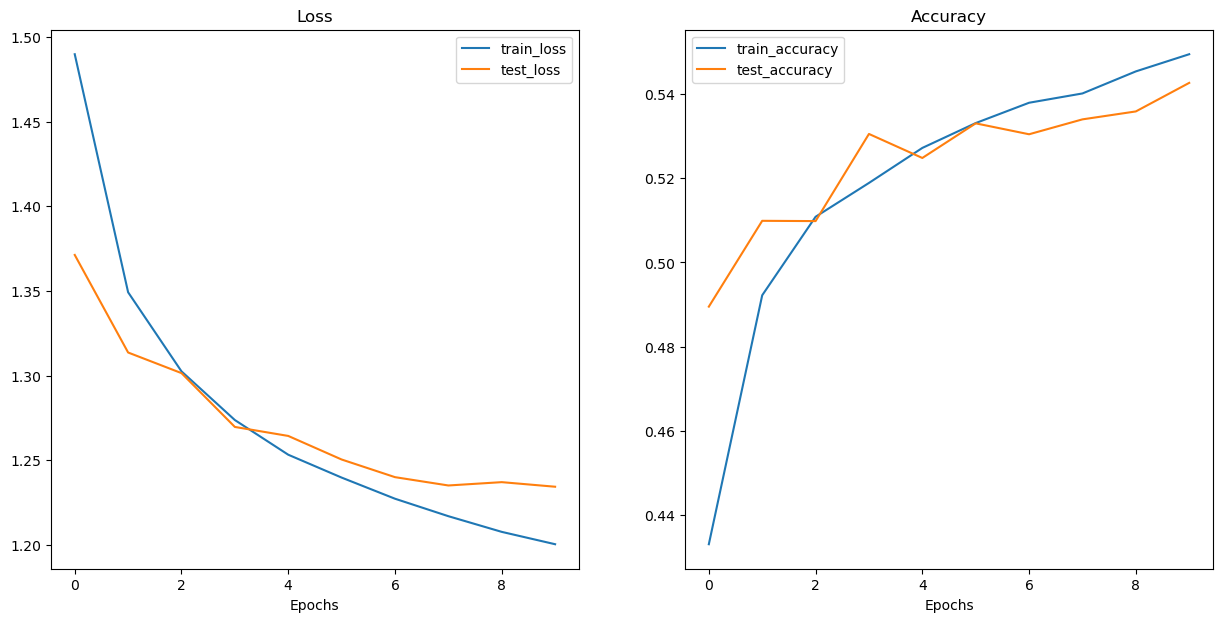

In [67]:
def plot_loss_curves(results):
    
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

plot_loss_curves(vit_results)

# **Prediction and Plotting**

In [68]:
def pred_and_plot_image(
    model: torch.nn.Module,
    class_names: List[str],
    image_path: str,
    image_size: Tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device = device,
):
   
    img = Image.open(image_path).convert("RGB")

    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )
    model.to(device)
    model.eval()
    with torch.inference_mode():
        transformed_image = image_transform(img).unsqueeze(dim=0)
        target_image_pred = model(transformed_image.to(device))

    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(
        f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.2f}"
    )
    plt.axis(False) 

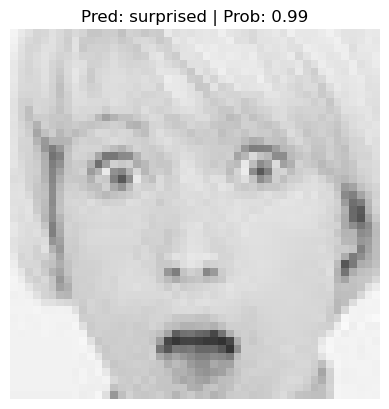

In [69]:
image_path = "/kaggle/input/capstone-dataset1/capstone/test/surprise/10185.jpg"
# image_path = "/kaggle/input/capstone-dataset1/capstone/test/fear/10044.jpg"
# image_path = "/kaggle/input/capstone-dataset1/capstone/test/angry/1024.jpg"


pred_and_plot_image(model=train_vit,
                    image_path= image_path,
                    class_names=class_names)

# Transfer Laerning

In [70]:
for parameter in train_vit.parameters():
    parameter.requires_grad = False
    
class_names = ['stress','no stress']

set_seeds()
train_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)


In [71]:
summary(model=train_vit, 
        input_size=(32, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 2]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [72]:
train_dir = '/kaggle/input/stress-capstone/stress-dataset/train'
test_dir = '/kaggle/input/stress-capstone/stress-dataset/test'

In [73]:
vit_transforms = vit_weights.transforms()
print(vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [74]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  new_class_names = train_data.classes

  new_train_loader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  new_test_loader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return new_train_loader, new_test_loader, new_class_names

In [75]:
new_train_dataloader, new_test_dataloader, class_names_new = create_dataloaders(train_dir=train_dir,
                                                                                test_dir=test_dir,
                                                                                transform=vit_transforms,
                                                                                batch_size=32)

In [76]:
optimizer = torch.optim.Adam(params=train_vit.parameters(), 
                             lr=3e-4) 
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
vit_result = train(model=train_vit,
                    train_dataloader= new_train_dataloader,
                    test_dataloader= new_test_dataloader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=10,
                    device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5961 | train_acc: 0.6796 | test_loss: 0.5639 | test_acc: 0.7156
Epoch: 2 | train_loss: 0.5551 | train_acc: 0.7182 | test_loss: 0.5408 | test_acc: 0.7314
Epoch: 3 | train_loss: 0.5391 | train_acc: 0.7287 | test_loss: 0.5316 | test_acc: 0.7369
Epoch: 4 | train_loss: 0.5306 | train_acc: 0.7321 | test_loss: 0.5255 | test_acc: 0.7379
Epoch: 5 | train_loss: 0.5247 | train_acc: 0.7391 | test_loss: 0.5238 | test_acc: 0.7407
Epoch: 6 | train_loss: 0.5206 | train_acc: 0.7414 | test_loss: 0.5197 | test_acc: 0.7397
Epoch: 7 | train_loss: 0.5161 | train_acc: 0.7438 | test_loss: 0.5173 | test_acc: 0.7419
Epoch: 8 | train_loss: 0.5125 | train_acc: 0.7460 | test_loss: 0.5161 | test_acc: 0.7432
Epoch: 9 | train_loss: 0.5098 | train_acc: 0.7487 | test_loss: 0.5143 | test_acc: 0.7444
Epoch: 10 | train_loss: 0.5087 | train_acc: 0.7507 | test_loss: 0.5124 | test_acc: 0.7471


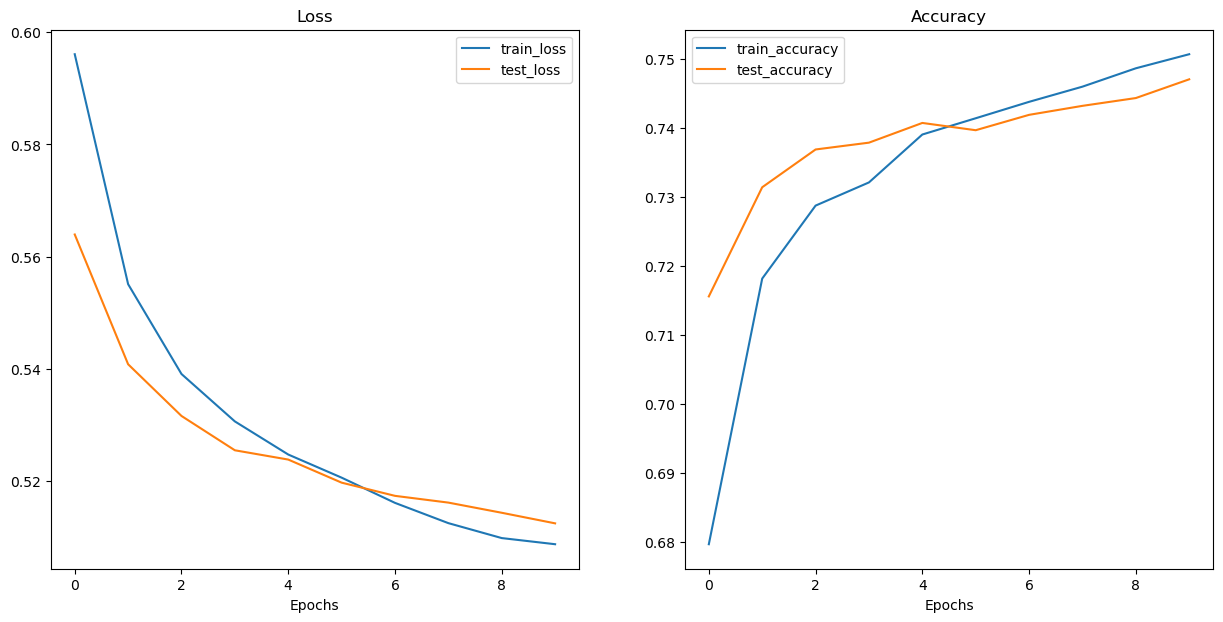

In [77]:
def plot_loss_curves(pretrained_vit_result):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = vit_result["train_loss"]
    test_loss = vit_result["test_loss"]

    accuracy = vit_result["train_acc"]
    test_accuracy = vit_result["test_acc"]

    epochs = range(len(vit_result["train_loss"]))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

plot_loss_curves(vit_result)

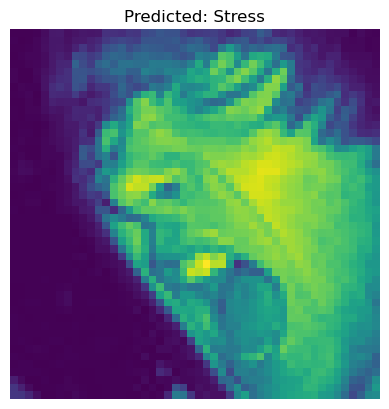

In [78]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def predict_and_plot_single_image(model, image_path, device, class_names):
    model.eval()  
    
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    
    plt.imshow(plt.imread(image_path))
    plt.title(f"Predicted: {class_names[predicted.item()]}")
    plt.axis('off')
    plt.show()

class_names = ['No Stress', 'Stress']  

test_image_path = '/kaggle/input/stress-capstone/stress-dataset/test/stress/10004.jpg'

model = train_vit

predict_and_plot_single_image(model, test_image_path, device, class_names)